In [1]:
import pandas as pd
import numpy as np
import re
import email
from itertools import chain

import networkx as nx
import plotly
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
df = pd.read_csv('../data/emails.csv')

In [3]:
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB


## Define functions for data pre-processing

In [5]:
def get_user(df):
    """
    Input:
        DataFrame
    Function:
        Extracts the user account in the column 'file' of the DataFrame and appends it to a list. Appends this 
        list as column 'user' to the dataframe and returns it.
    Output:
        DataFrame
    """
    file_split = []
    
    for file in df['file']:
        split = file.rsplit('/')
        file_split.append(split[0])
        
    df['user'] = file_split
        
    return df

In [6]:
def get_email_from_string(raw_email):
    """
    Input:
        String
    Function:
        Extracts header and contant information from a string representing a MIME type email. Converts the 
        header information to keys and the respective content as values and returns a dictionary.
    Output:
        Dictionary
    """
    
    msg = email.message_from_string(raw_email)
    
    content = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            content.append(part.get_payload())
            
    result = {}
    for key in msg.keys(): 
        result[key] = msg[key]
    result["content"] = ''.join(content)
    
    return result

In [7]:
def prep_dataframe(df):
    """
    Input:
        DataFrame
    Function:
        - Extracts columns "From", "To", "Cc" and "Bcc" from original DataFrame to a new DataFrame
        - Merges columns "To", "Cc" and "Bcc" in new DataFrame to new column "recipients"
        - Renames column "From" to "sender" in new DataFrame
        - Drops columns "To", "Cc" and "Bcc" from new DataFrame
    Output:
        DataFrame
    """
    
    df_short = df[['From', 'To', 'Cc', 'Bcc']]
    
    df_short['recipients'] = df_short[df_short.columns[1:]].apply(
    lambda x: ','.join(x.dropna()),
    axis=1)
    
    df_short = df_short.rename(columns={'From': 'sender',
                                       'X-Origin': 'email_account',
                                       'Date': 'date'})
    
    df_short.drop(columns=['To', 'Cc', 'Bcc'], inplace=True)
    
    df_short['recipients'].str.replace(' \n\t', '')
    
    df_short = df_short[['sender', 'recipients']]
    
    return df_short

In [8]:
def get_pairwise_communication(df_col1, df_col2):
    """
    Input:
        DataFrame columns
    Function:
        If recipient column contains multiple recipients, extracts individual recipients from recipient column 
        and matches row-wise with respective sender. Returns a DataFrame.
    Output:
        DataFrame
    """
         
    result_df = pd.DataFrame({ "sender" : np.repeat(df_col1.values, df_col2.str.len()),
                              "recipient": list(chain.from_iterable(df_col2))})
    
    
    
    return result_df

## Take a random sample for testing purposes in the pre-processing stage

In [9]:
test = df.sample(n=200, random_state=0)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 510816 to 109074
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file     200 non-null    object
 1   message  200 non-null    object
dtypes: object(2)
memory usage: 4.7+ KB


## Subsets with emails in sent folders only

In [11]:
# filter for emails in sent folders only
sent_emails = df.loc[df['file'].str.contains('sent')]
sent_emails

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...
...,...,...
517396,zufferli-j/sent_items/95.,Message-ID: <26807948.1075842029936.JavaMail.e...
517397,zufferli-j/sent_items/96.,Message-ID: <25835861.1075842029959.JavaMail.e...
517398,zufferli-j/sent_items/97.,Message-ID: <28979867.1075842029988.JavaMail.e...
517399,zufferli-j/sent_items/98.,Message-ID: <22052556.1075842030013.JavaMail.e...


In [12]:
sent_emails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126846 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     126846 non-null  object
 1   message  126846 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB


### Ken Lay's and Jeffrey Skilling's emails (sent only)

- Ken Lay was the founder, Chairman and long-term CEO of Enron
- Jeffrey Skilling was Enron's long-term COO and CEO for a brief period (02/2001 - 08/2001)

In [13]:
lay_skilling = sent_emails.loc[sent_emails['file'].str.contains('lay-k|skilling-j')]
lay_skilling

,file,message
267814,lay-k/_sent/1.,Message-ID: <18133935.1075840283210.JavaMail.e...
267815,lay-k/_sent/10.,Message-ID: <2156358.1075840283423.JavaMail.ev...
267816,lay-k/_sent/100.,Message-ID: <20840329.1075840285588.JavaMail.e...
267817,lay-k/_sent/101.,Message-ID: <22263156.1075840285610.JavaMail.e...
267818,lay-k/_sent/102.,Message-ID: <11395510.1075840285634.JavaMail.e...
...,...,...
446466,skilling-j/sent/95.,Message-ID: <15670774.1075840102133.JavaMail.e...
446467,skilling-j/sent/96.,Message-ID: <9961972.1075840102156.JavaMail.ev...
446468,skilling-j/sent/97.,Message-ID: <27813000.1075840102178.JavaMail.e...
446469,skilling-j/sent/98.,Message-ID: <6314782.1075840102206.JavaMail.ev...


### Vincent J. Kaminski's emails (complete email account)

- Enron's managing director for research
- responsible for quantitative modeling to assist Enron's energy trading and other parts of the business
- in the month's preceding Enron's bankrupty, Kaminski repeatedly raised strong objections to the financial practices of then Enron's CFO, Andrew Fastow, designed to conceal Enron's true debt.

In [14]:
kaminski = df.loc[df['file'].str.contains('kaminski')]
kaminski

,file,message
198895,kaminski-v/_sent_mail/1.,Message-ID: <28519439.1075856498412.JavaMail.e...
198896,kaminski-v/_sent_mail/10.,Message-ID: <27897591.1075856498629.JavaMail.e...
198897,kaminski-v/_sent_mail/100.,Message-ID: <28538884.1075856500656.JavaMail.e...
198898,kaminski-v/_sent_mail/1000.,Message-ID: <1815195.1075856526599.JavaMail.ev...
198899,kaminski-v/_sent_mail/1001.,Message-ID: <7019447.1075856526621.JavaMail.ev...
...,...,...
227355,kaminski-v/weather/5.,Message-ID: <12459994.1075856643488.JavaMail.e...
227356,kaminski-v/weather/6.,Message-ID: <1924374.1075856643511.JavaMail.ev...
227357,kaminski-v/weather/7.,Message-ID: <30050260.1075856643538.JavaMail.e...
227358,kaminski-v/weather/8.,Message-ID: <26973477.1075856643560.JavaMail.e...


In [15]:
kaminski.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28465 entries, 198895 to 227359
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file     28465 non-null  object
 1   message  28465 non-null  object
dtypes: object(2)
memory usage: 667.1+ KB


### Vincent J. Kaminski's emails (sent only)

In [16]:
kaminski_sent = sent_emails.loc[sent_emails['file'].str.contains('kaminski')]
kaminski_sent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8644 entries, 198895 to 226656
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file     8644 non-null   object
 1   message  8644 non-null   object
dtypes: object(2)
memory usage: 202.6+ KB


## Extract all relevant information from message string to DataFrame

### I. Test Sample 

In [17]:
test_parsed = pd.DataFrame(list(map(get_email_from_string, test['message'])))

In [18]:
test_parsed.head()

,Message-ID,Date,From,To,Subject,Cc,Mime-Version,Content-Type,Content-Transfer-Encoding,Bcc,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content
0,<20978984.1075839990072.JavaMail.evans@thyme>,"Thu, 13 Dec 2001 06:37:39 -0800 (PST)",pete.davis@enron.com,pete.davis@enron.com,Start Date: 12/13/01; HourAhead hour: 5;,"albert.meyers@enron.com, bill.williams@enron.c...",1.0,text/plain; charset=us-ascii,7bit,"albert.meyers@enron.com, bill.williams@enron.c...","Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=P...","Davis, Pete </O=ENRON/OU=NA/CN=RECIPIENTS/CN=P...","Meyers, Albert </O=ENRON/OU=NA/CN=RECIPIENTS/C...",,"\ExMerge - Williams III, Bill\Schedule Crawler",WILLIAMS-W3,,\n\nStart Date: 12/13/01; HourAhead hour: 5; ...
1,<8987828.1075842774735.JavaMail.evans@thyme>,"Tue, 20 Mar 2001 00:12:00 -0800 (PST)",tyrell.harrison@enron.com,gerald.nemec@enron.com,Executed letter agreements,barry.tycholiz@enron.com,1.0,text/plain; charset=us-ascii,7bit,barry.tycholiz@enron.com,Tyrell Harrison,Gerald Nemec,Barry Tycholiz,,\Gerald_Nemec_Dec2000_June2001_2\Notes Folders...,NEMEC-G,gnemec.nsf,- Gerald\n\nBarry should have the executed let...
2,<30686869.1075860369073.JavaMail.evans@thyme>,"Thu, 15 Mar 2001 01:30:00 -0800 (PST)",rcarroll@bracepatt.com,"cyoder@enron.com, jsteffe@enron.com, rsanders@...",Interventions in Tuscon Complaint Proceeding,"acomnes@enron.com, jhartso@enron.com, mary.hai...",1.0,text/plain; charset=us-ascii,7bit,"acomnes@enron.com, jhartso@enron.com, mary.hai...","""Ronald Carroll"" <rcarroll@bracepatt.com>","<cyoder@enron.com>, <jsteffe@enron.com>, <rsan...","<acomnes@enron.com>, <jhartso@enron.com>, <mar...",,\Mary_Hain_Aug2000_Jul2001\Notes Folders\All d...,Hain-M,mary-hain.nsf,Just a reminder that interventions and comment...
3,<4155293.1075842841039.JavaMail.evans@thyme>,"Wed, 3 Jan 2001 10:00:00 -0800 (PST)",dwight.beach@enron.com,gerald.nemec@enron.com,GROUND LEASE (ELIZABETHTOWN).doc,NaN,1.0,text/plain; charset=us-ascii,7bit,NaN,Dwight Beach,Gerald Nemec,,,\Gerald_Nemec_Dec2000_June2001_2\Notes Folders...,NEMEC-G,gnemec.nsf,"I think that these are current, but you might ..."
4,<12670521.1075862605089.JavaMail.evans@thyme>,"Wed, 26 Sep 2001 07:59:09 -0700 (PDT)",l..denton@enron.com,"kysa.alport@enron.com, w..white@enron.com, way...","IDACORP Energy, LP",NaN,1.0,text/plain; charset=us-ascii,7bit,NaN,"Denton, Rhonda L. </O=ENRON/OU=NA/CN=RECIPIENT...","Alport, Kysa </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...",,,"\DBAUGHM (Non-Privileged)\Baughman Jr., Don\Po...",Baughman-D,DBAUGHM (Non-Privileged).pst,"Idaho Power Company, dba IdaCorp Energy, the u..."


In [19]:
test_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Message-ID                 200 non-null    object
 1   Date                       200 non-null    object
 2   From                       200 non-null    object
 3   To                         193 non-null    object
 4   Subject                    200 non-null    object
 5   Cc                         54 non-null     object
 6   Mime-Version               200 non-null    object
 7   Content-Type               200 non-null    object
 8   Content-Transfer-Encoding  200 non-null    object
 9   Bcc                        54 non-null     object
 10  X-From                     200 non-null    object
 11  X-To                       200 non-null    object
 12  X-cc                       200 non-null    object
 13  X-bcc                      200 non-null    object
 14  X-Folder  

In [20]:
test_parsed.describe()

,Message-ID,Date,From,To,Subject,Cc,Mime-Version,Content-Type,Content-Transfer-Encoding,Bcc,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content
count,200,200,200,193,200,54,200,200,200,54,200,200,200,200,200,200,200,200
unique,200,200,141,174,187,50,1,2,2,50,149,182,52,1,161,92,96,200
top,<16173240.1075849761227.JavaMail.evans@thyme>,"Mon, 14 May 2001 02:29:00 -0700 (PDT)",steven.kean@enron.com,sara.shackleton@enron.com,,"bert.meyers@enron.com, bill.williams.iii@enron...",1.0,text/plain; charset=us-ascii,7bit,"bert.meyers@enron.com, bill.williams.iii@enron...",Steven J Kean,Sara Shackleton,,,\Jeff_Dasovich_June2001\Notes Folders\All docu...,DASOVICH-J,jdasovic.nsf,---------------------- Forwarded by Darron C G...
freq,1,1,8,4,10,3,200,181,188,3,8,3,145,200,6,14,14,1


In [21]:
# display unique email user accounts (i.e. employees) and the number of emails per account
accounts = test_parsed['X-Origin'].value_counts()
accounts

DASOVICH-J       14
SHACKLETON-S     12
KEAN-S           11
Kaminski-V       10
SYMES-K           9
                 ..
HENDRICKSON-S     1
SEMPERGER-C       1
WOLFE-J           1
Sanders-R         1
Dickson-S         1
Name: X-Origin, Length: 92, dtype: int64

In [22]:
# show missing values
test_parsed.isna().sum()

Message-ID                     0
Date                           0
From                           0
To                             7
Subject                        0
Cc                           146
Mime-Version                   0
Content-Type                   0
Content-Transfer-Encoding      0
Bcc                          146
X-From                         0
X-To                           0
X-cc                           0
X-bcc                          0
X-Folder                       0
X-Origin                       0
X-FileName                     0
content                        0
dtype: int64

### II. Complete Dataset

In [23]:
df_parsed = pd.DataFrame(list(map(get_email_from_string, df['message'])))

In [24]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Message-ID                 517401 non-null  object
 1   Date                       517401 non-null  object
 2   From                       517401 non-null  object
 3   To                         495554 non-null  object
 4   Subject                    517401 non-null  object
 5   Mime-Version               517372 non-null  object
 6   Content-Type               517372 non-null  object
 7   Content-Transfer-Encoding  517372 non-null  object
 8   X-From                     517372 non-null  object
 9   X-To                       517372 non-null  object
 10  X-cc                       517372 non-null  object
 11  X-bcc                      517372 non-null  object
 12  X-Folder                   517372 non-null  object
 13  X-Origin                   517372 non-null  

In [25]:
# Display relevant statistics about dataset
df_parsed.describe()

,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,...,X-bcc,X-Folder,X-Origin,X-FileName,content,Cc,Bcc,Time,Attendees,Re
count,517401,517401,517401,495554,517401,517372,517372,517372,517372,517372,...,517372,517372,517372,517372,517401,127881,127881,1,2,2
unique,517401,224128,20328,58563,159290,1,2,3,27980,73552,...,132,5335,259,429,249025,29595,29595,1,1,1
top,<30853411.1075853926667.JavaMail.evans@thyme>,"Wed, 27 Jun 2001 16:02:00 -0700 (PDT)",kay.mann@enron.com,pete.davis@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Kay Mann,,...,,\Kay_Mann_June2001_1\Notes Folders\All documents,Kaminski-V,vkamins.nsf,"As you know, Enron Net Works (ENW) and Enron G...","albert.meyers@enron.com, bill.williams@enron.c...","albert.meyers@enron.com, bill.williams@enron.c...",9:00am -\n 10:00am,"Martin Chavez, CEO & Founder of Kiodex, Raj\n ...",Fitzgertald project Kiodex
freq,1,1118,16735,9155,19187,517372,479286,494971,16324,9124,...,517197,6639,26995,24029,112,3106,3106,1,2,2


In [26]:
df_parsed.head()

,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,...,X-bcc,X-Folder,X-Origin,X-FileName,content,Cc,Bcc,Time,Attendees,Re
0,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,...,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,NaN,NaN,NaN,NaN,NaN
1,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,...,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,NaN,NaN,NaN,NaN,NaN
2,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,...,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,NaN,NaN,NaN,NaN,NaN
3,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,...,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",NaN,NaN,NaN,NaN,NaN
4,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,...,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,NaN,NaN,NaN,NaN,NaN


In [27]:
# show missing values
df_parsed.isna().sum()

Message-ID                        0
Date                              0
From                              0
To                            21847
Subject                           0
Mime-Version                     29
Content-Type                     29
Content-Transfer-Encoding        29
X-From                           29
X-To                             29
X-cc                             29
X-bcc                            29
X-Folder                         29
X-Origin                         29
X-FileName                       29
content                           0
Cc                           389520
Bcc                          389520
Time                         517400
Attendees                    517399
Re                           517399
dtype: int64

In [28]:
empty_recipients = df_parsed[df_parsed['To'].isna()]
empty_recipients.head()

,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,...,X-bcc,X-Folder,X-Origin,X-FileName,content,Cc,Bcc,Time,Attendees,Re
188,<15201149.1075855691021.JavaMail.evans@thyme>,"Mon, 1 May 2000 03:56:00 -0700 (PDT)",phillip.allen@enron.com,NaN,Re: DSL- Installs,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Circuit Provisioning@ENRON,...,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,No one will be home on 5/11/00 to meet DSL ins...,NaN,NaN,NaN,NaN,NaN
603,<21975671.1075855665520.JavaMail.evans@thyme>,"Wed, 13 Dec 2000 08:35:00 -0800 (PST)",messenger@ecm.bloomberg.com,NaN,Bloomberg Power Lines Report,1.0,text/plain; charset=ANSI_X3.4-1968,quoted-printable,"""Bloomberg.com"" <messenger@ecm.bloomberg.com>",(undisclosed-recipients),...,,\Phillip_Allen_Dec2000\Notes Folders\All docum...,Allen-P,pallen.nsf,Here is today's copy of Bloomberg Power Lines....,NaN,NaN,NaN,NaN,NaN
781,<9828978.1075855671241.JavaMail.evans@thyme>,"Mon, 1 May 2000 03:56:00 -0700 (PDT)",phillip.allen@enron.com,NaN,Re: DSL- Installs,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Circuit Provisioning@ENRON,...,,\Phillip_Allen_Dec2000\Notes Folders\All docum...,Allen-P,pallen.nsf,No one will be home on 5/11/00 to meet DSL ins...,NaN,NaN,NaN,NaN,NaN
873,<8236042.1075855673105.JavaMail.evans@thyme>,"Fri, 7 Jan 2000 16:23:00 -0800 (PST)",owner-strawbale@crest.org,NaN,,1.0,text/plain; charset=us-ascii,7bit,owner-strawbale@crest.org,"undisclosed-recipients:,",...,,\Phillip_Allen_Dec2000\Notes Folders\All docum...,Allen-P,pallen.nsf,<4DDE116DBCA1D3118B130080C840BAAD02CD53@ppims....,NaN,NaN,NaN,NaN,NaN
885,<26959382.1075855693279.JavaMail.evans@thyme>,"Mon, 14 May 2001 09:04:00 -0700 (PDT)",messenger@ecm.bloomberg.com,NaN,Bloomberg Power Lines Report,1.0,text/plain; charset=ANSI_X3.4-1968,quoted-printable,"""Bloomberg.com"" <messenger@ecm.bloomberg.com>",(undisclosed-recipients),...,,\Phillip_Allen_June2001\Notes Folders\All docu...,Allen-P,pallen.nsf,Here is today's copy of Bloomberg Power Lines....,NaN,NaN,NaN,NaN,NaN


## Extract relevant info from original DataFrame to new DataFrame

In [29]:
comms = prep_dataframe(test_parsed)
comms

/home/agnes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sender,recipients
0,pete.davis@enron.com,"pete.davis@enron.com,albert.meyers@enron.com, ..."
1,tyrell.harrison@enron.com,"gerald.nemec@enron.com,barry.tycholiz@enron.co..."
2,rcarroll@bracepatt.com,"cyoder@enron.com, jsteffe@enron.com, rsanders@..."
3,dwight.beach@enron.com,gerald.nemec@enron.com
4,l..denton@enron.com,"kysa.alport@enron.com, w..white@enron.com, way..."
...,...,...
195,steven.kean@enron.com,jeff.dasovich@enron.com
196,jane.tholt@enron.com,"phillip.allen@enron.com, barry.tycholiz@enron.com"
197,jr..legal@enron.com,dl-ga-all_enron_worldwide1@enron.com
198,eric.bass@enron.com,shanna.husser@enron.com


In [30]:
# show missing values
comms.isna().sum()

sender        0
recipients    0
dtype: int64

## Break down multiple recipients per email/ sender to one recipient per row and sender

In [31]:
comms['recipients'] = comms['recipients'].apply(lambda x: x.split(','))

In [32]:
comms_full = get_pairwise_communication(comms['sender'], comms['recipients'])

In [33]:
comms_full

,sender,recipient
0,pete.davis@enron.com,pete.davis@enron.com
1,pete.davis@enron.com,albert.meyers@enron.com
2,pete.davis@enron.com,bill.williams@enron.com
3,pete.davis@enron.com,craig.dean@enron.com
4,pete.davis@enron.com,\n\tgeir.solberg@enron.com
...,...,...
1836,jane.tholt@enron.com,phillip.allen@enron.com
1837,jane.tholt@enron.com,barry.tycholiz@enron.com
1838,jr..legal@enron.com,dl-ga-all_enron_worldwide1@enron.com
1839,eric.bass@enron.com,shanna.husser@enron.com


In [34]:
pete_davis = comms_full[comms_full['sender'].str.contains('pete.davis.enron.com')]
pete_davis

,sender,recipient
0,pete.davis@enron.com,pete.davis@enron.com
1,pete.davis@enron.com,albert.meyers@enron.com
2,pete.davis@enron.com,bill.williams@enron.com
3,pete.davis@enron.com,craig.dean@enron.com
4,pete.davis@enron.com,\n\tgeir.solberg@enron.com
...,...,...
1084,pete.davis@enron.com,leaf.harasin@enron.com
1085,pete.davis@enron.com,\n\tmonika.causholli@enron.com
1086,pete.davis@enron.com,mark.guzman@enron.com
1087,pete.davis@enron.com,\n\tpete.davis@enron.com


In [35]:
"""
email_dict = {'sender': [],
             'recipient': []}
for i in comms['recipients'][0].split(','):
    email_dict['sender'].append(comms['sender'][0])
    email_dict['recipient'].append(i)
"""
"""
email_dict = {'sender': [],
            'recipient': []}
for index, row in comms.head().iterrows():
    for i in row['recipients'][index].split(','):
        email_dict['sender'].append(row['sender'][index])
        email_dict['recipient'].append(i)
"""

"\nemail_dict = {'sender': [],\n            'recipient': []}\nfor index, row in comms.head().iterrows():\n    for i in row['recipients'][index].split(','):\n        email_dict['sender'].append(row['sender'][index])\n        email_dict['recipient'].append(i)\n"

In [36]:
list_sender = comms_full['sender'].unique()
len(list_sender)

141

In [37]:
list_recipients = comms_full['recipient'].unique()
len(list_recipients)

1348

In [38]:
unique_addresses = list(set(list_sender) | set(list_recipients))

In [39]:
len(unique_addresses)

1461

## Test Sample Network Analysis

In [40]:
G = nx.from_pandas_edgelist(pete_davis, 'sender', 'recipient')

/home/agnes/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/agnes/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


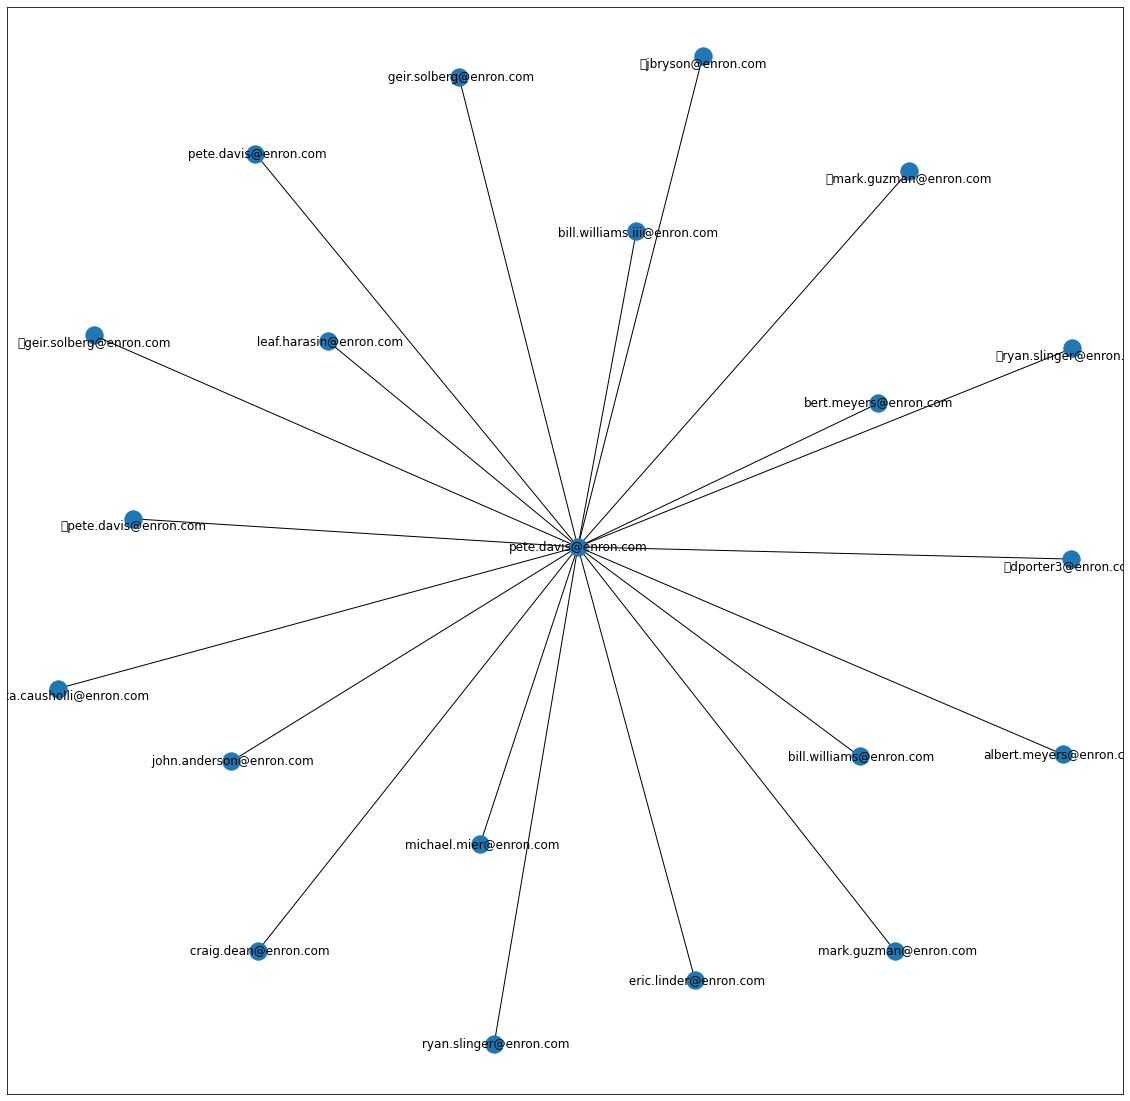

In [41]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=1)
nx.draw_networkx(G, pos)

# Analysis of Vincent Kaminski's emails

## Based on all items in Kaminski's email account

In [42]:
kaminski_parsed = pd.DataFrame(list(map(get_email_from_string, kaminski['message'])))
kaminski_parsed.head()

,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,Cc,Bcc
0,<28519439.1075856498412.JavaMail.evans@thyme>,"Mon, 7 May 2001 08:41:00 -0700 (PDT)",vince.kaminski@enron.com,"stephen.stock@enron.com, beth.perlman@enron.com",A resume for Londom,1.0,text/plain; charset=us-ascii,7bit,Vince J Kaminski,"Stephen Stock, Beth Perlman",,,\Vincent_Kaminski_Jun2001_4\Notes Folders\'sen...,Kaminski-V,vkamins.nsf,This is a resume of one guy I met in Houston a...,NaN,NaN
1,<27897591.1075856498629.JavaMail.evans@thyme>,"Mon, 7 May 2001 05:28:00 -0700 (PDT)",vince.kaminski@enron.com,vkaminski@aol.com,Btu's Weekly Power Report,1.0,text/plain; charset=us-ascii,7bit,Vince J Kaminski,vkaminski@aol.com,,,\Vincent_Kaminski_Jun2001_4\Notes Folders\'sen...,Kaminski-V,vkamins.nsf,---------------------- Forwarded by Vince J Ka...,NaN,NaN
2,<28538884.1075856500656.JavaMail.evans@thyme>,"Mon, 30 Apr 2001 08:47:00 -0700 (PDT)",vince.kaminski@enron.com,vkaminski@aol.com,,1.0,text/plain; charset=us-ascii,7bit,Vince J Kaminski,vkaminski@aol.com,,,\Vincent_Kaminski_Jun2001_4\Notes Folders\'sen...,Kaminski-V,vkamins.nsf,"http://www.x10.com/home/offer.cgi?!BF1,../blue...",NaN,NaN
3,<1815195.1075856526599.JavaMail.evans@thyme>,"Fri, 12 Jan 2001 08:07:00 -0800 (PST)",vince.kaminski@enron.com,stinson.gibner@enron.com,update on energy book,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,Vince J Kaminski,Stinson Gibner,,,\Vincent_Kaminski_Jun2001_4\Notes Folders\'sen...,Kaminski-V,vkamins.nsf,FYI\n\nVince\n---------------------- Forwarded...,NaN,NaN
4,<7019447.1075856526621.JavaMail.evans@thyme>,"Fri, 12 Jan 2001 08:05:00 -0800 (PST)",vince.kaminski@enron.com,stinson.gibner@enron.com,update on energy book,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,Vince J Kaminski,Stinson Gibner,,,\Vincent_Kaminski_Jun2001_4\Notes Folders\'sen...,Kaminski-V,vkamins.nsf,---------------------- Forwarded by Vince J Ka...,NaN,NaN


In [43]:
kaminski_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28465 entries, 0 to 28464
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Message-ID                 28465 non-null  object
 1   Date                       28465 non-null  object
 2   From                       28465 non-null  object
 3   To                         27801 non-null  object
 4   Subject                    28465 non-null  object
 5   Mime-Version               28463 non-null  object
 6   Content-Type               28463 non-null  object
 7   Content-Transfer-Encoding  28463 non-null  object
 8   X-From                     28463 non-null  object
 9   X-To                       28463 non-null  object
 10  X-cc                       28463 non-null  object
 11  X-bcc                      28463 non-null  object
 12  X-Folder                   28463 non-null  object
 13  X-Origin                   28463 non-null  object
 14  X-File

In [44]:
kaminski_parsed.describe()

,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,Cc,Bcc
count,28465,28465,28465,27801,28465,28463,28463,28463,28463,28463,28463,28463,28463,28463,28463,28465,10336,10336
unique,28465,11177,1503,2581,7449,1,2,2,1846,3416,1679,8,129,2,5,11424,1413,1413
top,<11237918.1075856233235.JavaMail.evans@thyme>,"Mon, 31 Dec 1979 16:00:00 -0800 (PST)",vince.kaminski@enron.com,vkaminski@aol.com,,1.0,text/plain; charset=us-ascii,7bit,Vince J Kaminski,vkaminski@aol.com,,,\Vincent_Kaminski_Jun2001_1\Notes Folders\All ...,Kaminski-V,vkamins.nsf,"Christie,\n\nShirley reserved room 49C1 for Mo...",vince.kaminski@enron.com,vince.kaminski@enron.com
freq,1,25,14335,4870,935,28463,25642,27067,14335,4125,18042,28452,5066,26995,24029,6,3046,3046


In [45]:
kaminski_parsed['X-Origin'].unique()

array(['Kaminski-V', 'KAMINSKI-V', nan], dtype=object)

In [46]:
kaminski_parsed['From'].value_counts()

vince.kaminski@enron.com                 14335
j.kaminski@enron.com                      1235
shirley.crenshaw@enron.com                 960
vkaminski@aol.com                          477
stinson.gibner@enron.com                   342
                                         ...  
polixenes.701@a-job.dk                       1
walton@enron.com                             1
mathworks-bounceback-pr@mathworks.com        1
abnjlc@earthlink.net                         1
euromoney@euromoney.com                      1
Name: From, Length: 1503, dtype: int64

In [47]:
kaminski_comm = prep_dataframe(kaminski_parsed)
kaminski_comm

/home/agnes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sender,recipients
0,vince.kaminski@enron.com,"stephen.stock@enron.com, beth.perlman@enron.com"
1,vince.kaminski@enron.com,vkaminski@aol.com
2,vince.kaminski@enron.com,vkaminski@aol.com
3,vince.kaminski@enron.com,stinson.gibner@enron.com
4,vince.kaminski@enron.com,stinson.gibner@enron.com
...,...,...
28460,mike.roberts@enron.com,vince.kaminski@enron.com
28461,paul.quilkey@enron.com,"mike.roberts@enron.com,christian.werner@enron...."
28462,mike.roberts@enron.com,"cary.carrabine@enron.com, richard.tomaski@enro..."
28463,mike.roberts@enron.com,"jeffrey.shankman@enron.com, jennifer.fraser@en..."


In [48]:
kaminski_comm['recipients'] = kaminski_comm['recipients'].apply(lambda x: x.split(','))

In [49]:
kaminski_full = get_pairwise_communication(kaminski_comm['sender'], kaminski_comm['recipients'])

In [50]:
kaminski_full

,sender,recipient
0,vince.kaminski@enron.com,stephen.stock@enron.com
1,vince.kaminski@enron.com,beth.perlman@enron.com
2,vince.kaminski@enron.com,vkaminski@aol.com
3,vince.kaminski@enron.com,vkaminski@aol.com
4,vince.kaminski@enron.com,stinson.gibner@enron.com
...,...,...
113919,christian.werner@enron.com,paul.quilkey@enron.com
113920,christian.werner@enron.com,mark.tawney@enron.com
113921,christian.werner@enron.com,vince.kaminski@enron.com
113922,christian.werner@enron.com,paul.quilkey@enron.com


In [51]:
kaminski_sender = kaminski_full[kaminski_full['sender'].str.contains('vince.kaminski.enron.com|j.kaminski@enron.com')]
kaminski_sender

,sender,recipient
0,vince.kaminski@enron.com,stephen.stock@enron.com
1,vince.kaminski@enron.com,beth.perlman@enron.com
2,vince.kaminski@enron.com,vkaminski@aol.com
3,vince.kaminski@enron.com,vkaminski@aol.com
4,vince.kaminski@enron.com,stinson.gibner@enron.com
...,...,...
113800,vince.kaminski@enron.com,joseph.hrgovcic@enron.com
113801,vince.kaminski@enron.com,mike.roberts@enron.com
113802,vince.kaminski@enron.com,vince.kaminski@enron.com
113803,vince.kaminski@enron.com,mike.roberts@enron.com


In [52]:
edges = kaminski_sender.value_counts(['sender', 'recipient'])
edges = edges.reset_index()

In [53]:
edges = edges.rename(columns={0: 'num_emails'})
edges

,sender,recipient,num_emails
0,vince.kaminski@enron.com,vince.kaminski@enron.com,8141
1,vince.kaminski@enron.com,vkaminski@aol.com,4936
2,vince.kaminski@enron.com,vince.kaminski@enron.com,1770
3,vince.kaminski@enron.com,shirley.crenshaw@enron.com,1619
4,vince.kaminski@enron.com,shirley.crenshaw@enron.com,1220
...,...,...,...
1481,j.kaminski@enron.com,focuscapital@msn.com,1
1482,j.kaminski@enron.com,figueroa@math.gatech.edu,1
1483,j.kaminski@enron.com,rebrooks@rbac.com,1
1484,j.kaminski@enron.com,eydie.corneiro@enron.com,1


### Create Network Graph for Kaminski
#### Add Nodes & Edges

Check out https://towardsdatascience.com/tutorial-network-visualization-basics-with-networkx-and-plotly-and-a-little-nlp-57c9bbb55bb9
part "Create Your Network Graph" for instruction how to create the graph

In [54]:
# create the graph
G = nx.from_pandas_edgelist(edges, 'sender', 'recipient', edge_attr='num_emails')

In [55]:
emails = [i['num_emails'] for i in dict(G.edges).values()]
emails

[8141,
 4936,
 1770,
 1619,
 1220,
 738,
 710,
 478,
 312,
 275,
 234,
 205,
 194,
 193,
 191,
 173,
 171,
 171,
 169,
 161,
 152,
 148,
 144,
 138,
 125,
 120,
 120,
 116,
 111,
 111,
 110,
 108,
 98,
 93,
 92,
 88,
 88,
 87,
 83,
 79,
 77,
 77,
 77,
 76,
 71,
 68,
 67,
 66,
 65,
 65,
 62,
 62,
 62,
 61,
 61,
 60,
 59,
 59,
 56,
 56,
 53,
 52,
 52,
 52,
 50,
 50,
 48,
 48,
 47,
 47,
 46,
 46,
 45,
 44,
 44,
 44,
 43,
 42,
 42,
 41,
 39,
 38,
 38,
 38,
 38,
 37,
 37,
 37,
 37,
 35,
 35,
 35,
 35,
 34,
 34,
 34,
 33,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 30,
 30,
 30,
 30,
 30,
 30,
 29,
 29,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 27,
 27,
 27,
 27,
 27,
 26,
 26,
 26,
 26,
 26,
 25,
 25,
 25,
 25,
 25,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 23,
 22,
 22,
 22,
 22,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 19,
 19,
 19,
 19,
 19,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 17,
 17,
 17

In [56]:
persons = [i for i in dict(G.nodes).keys()]
persons = {i:i for i in dict(G.nodes).keys()}
persons

{'vince.kaminski@enron.com': 'vince.kaminski@enron.com',
 'vkaminski@aol.com': 'vkaminski@aol.com',
 ' vince.kaminski@enron.com': ' vince.kaminski@enron.com',
 'shirley.crenshaw@enron.com': 'shirley.crenshaw@enron.com',
 ' shirley.crenshaw@enron.com': ' shirley.crenshaw@enron.com',
 'stinson.gibner@enron.com': 'stinson.gibner@enron.com',
 ' stinson.gibner@enron.com': ' stinson.gibner@enron.com',
 'j.kaminski@enron.com': 'j.kaminski@enron.com',
 ' vkaminski@aol.com': ' vkaminski@aol.com',
 ' vasant.shanbhogue@enron.com': ' vasant.shanbhogue@enron.com',
 'mike.roberts@enron.com': 'mike.roberts@enron.com',
 'vasant.shanbhogue@enron.com': 'vasant.shanbhogue@enron.com',
 'steven.leppard@enron.com': 'steven.leppard@enron.com',
 'grant.masson@enron.com': 'grant.masson@enron.com',
 ' zimin.lu@enron.com': ' zimin.lu@enron.com',
 ' grant.masson@enron.com': ' grant.masson@enron.com',
 ' \n\tshirley.crenshaw@enron.com': ' \n\tshirley.crenshaw@enron.com',
 ' mike.roberts@enron.com': ' mike.roberts@

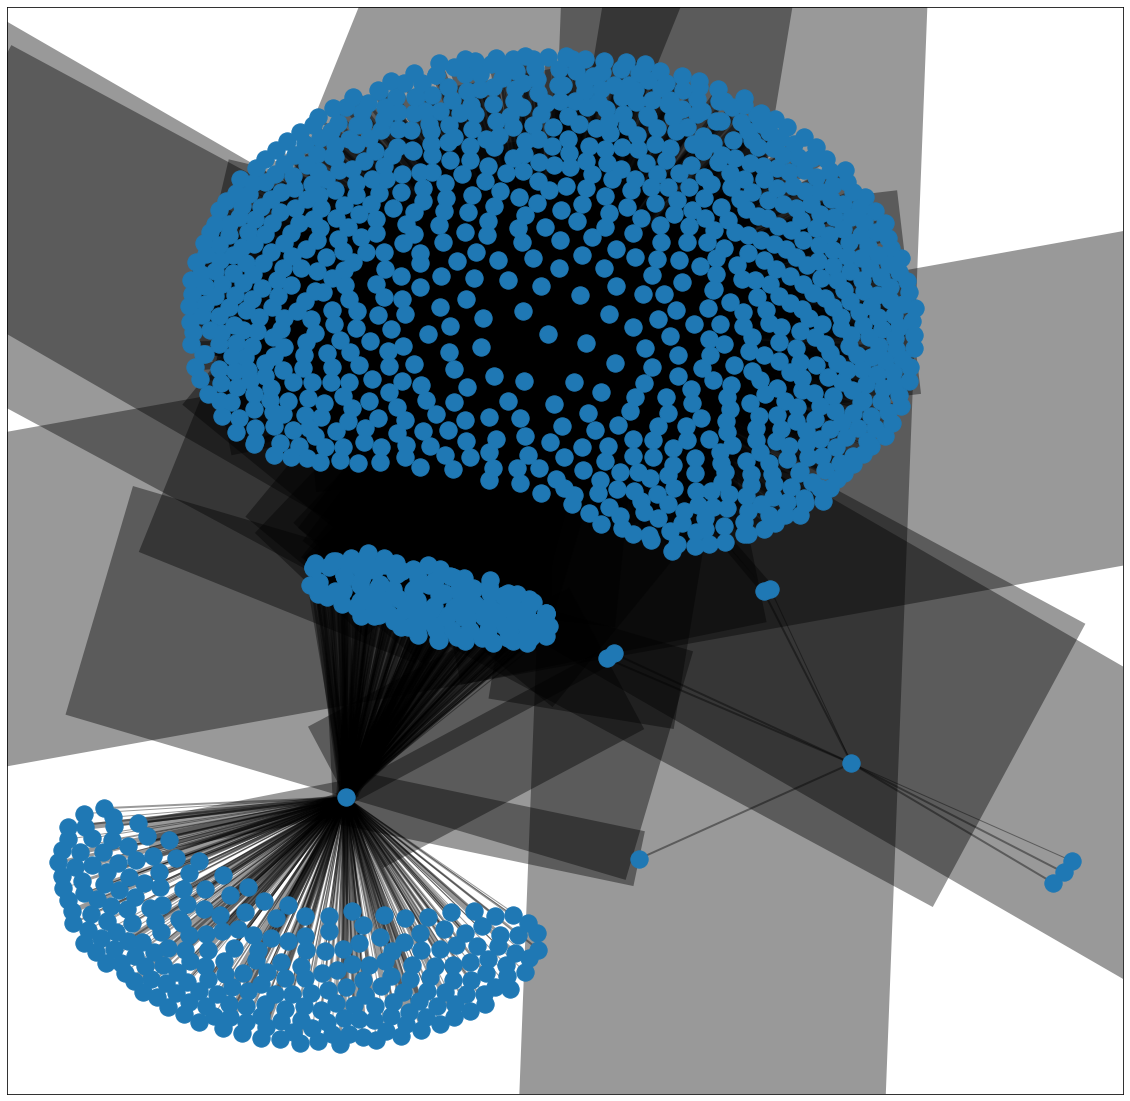

In [57]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G,)
nx.draw_networkx_nodes(G, pos, label=persons, cmap='Spectral')
nx.draw_networkx_edges(G, pos, width=emails, edge_cmap='Spectral', alpha=0.4)

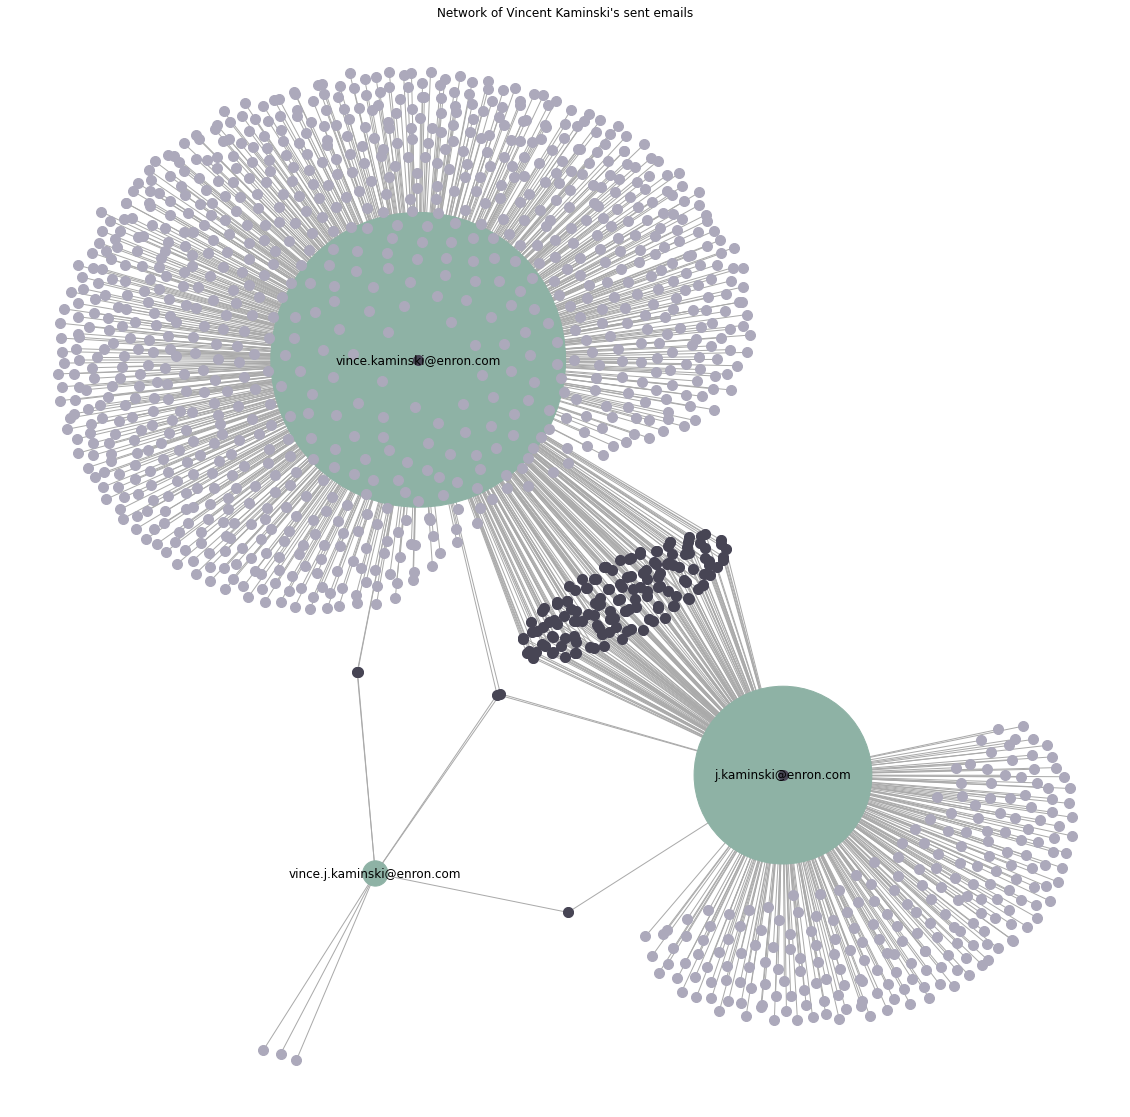

In [58]:
fig = plt.figure(figsize=(20, 20))

# create a layout for the nodes
layout = nx.spring_layout(G, iterations=50)

# draw the adges
nx.draw_networkx_edges(G, layout, edge_color='#AAAAAA')

# create and draw sender nodes, sized according to their number of connections
sender = [node for node in G.nodes() if node in edges['sender'].unique()]
size = [G.degree(node) * 80 for node in G.nodes() if node in edges['sender'].unique()]
nx.draw_networkx_nodes(G, layout, nodelist=sender, node_size=size, node_color='#8EB2A5')

# create and draw all recipient nodes
recipients = [node for node in G.nodes() if node in edges['recipient'].unique()]
nx.draw_networkx_nodes(G, layout, nodelist=recipients, node_size=100, node_color='#ACA9BB')

# create and draw popular recipients
high_degree_recipients = [node for node in G.nodes() if node in edges['recipient'].unique() and G.degree(node) > 1]
nx.draw_networkx_nodes(G, layout, nodelist=high_degree_recipients, node_size=100, node_color='#474554')

# label the sender nodes
sender_dict = dict(zip(sender, sender))
nx.draw_networkx_labels(G, layout, labels=sender_dict)

plt.axis('off')
plt.title('Network of Vincent Kaminski\'s sent emails', )
plt.show()


In [59]:
fig.savefig('../plots/kaminski_network.png')

## Based on send items only in Kaminski's email account